## Week 11 Homework (9)

### Q1: copulas

2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it
4. Describe how to use this to create arbitrary multivariate GLM regressions

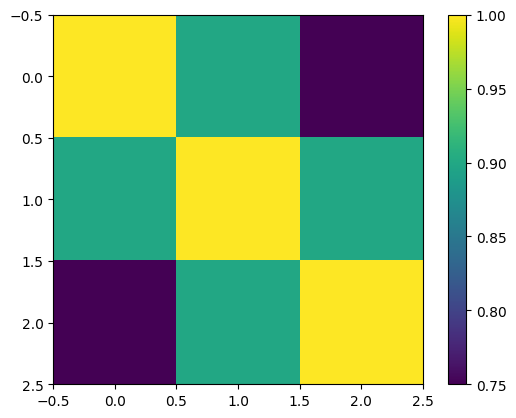

In [4]:
# Q1.2 Answer

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();

In [6]:
# Q1.2 Answer

y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

In [7]:
# Q1.2 Answer

import pymc as pm
import arviz as az

with pm.Model() as marginal_model:
    # Gamma marginal
    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:, 0])

    # Exponential marginal
    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:, 1])

    # Chi-squared marginal
    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:, 2])

    trace_marginals = pm.sample()


Output()

In [8]:
# Q1.2 Answer

post_means = az.summary(trace_marginals, var_names=["p0", "p1", "p2"])["mean"]
p0_mean, p1_mean, p2_mean = post_means

# Transform y into copula-normal space using inverse CDF (probit transform)
from scipy.stats import norm, gamma, expon, chi2

u0 = gamma(a=p0_mean).cdf(y[:, 0])
u1 = expon(scale=1/p1_mean).cdf(y[:, 1])
u2 = chi2(df=p2_mean).cdf(y[:, 2])

z = np.column_stack([norm.ppf(u0), norm.ppf(u1), norm.ppf(u2)])

In [9]:
# Q1.2 Answer

with pm.Model() as copula_model:
    L, R, stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0, shape=3),
                                   compute_corr=True)
    copula = pm.MvNormal("copula", mu=np.zeros(3), chol=L, observed=z)
    trace_copula = pm.sample()


Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

In [12]:
# Q1.2 Answer

# Get posterior samples of R_corr
corr_post = trace_copula.posterior["R_corr"].stack(samples=("chain", "draw")).values

# Focus on unique off-diagonal pairs
pairs = [(0, 1), (0, 2), (1, 2)]

import arviz as az
import numpy as np

# Extract and compute 95% HDIs for each correlation pair
hdi_corr_intervals = {}
for i, j in pairs:
    samples_ij = corr_post[:, i, j]  # shape: (n_samples,)
    hdi_ij = az.hdi(samples_ij, hdi_prob=0.95)
    hdi_corr_intervals[f"({i},{j})"] = hdi_ij

# Print nicely formatted results
for pair, interval in hdi_corr_intervals.items():
    lower, upper = interval
    print(f"95% HDI for correlation {pair}: [{lower:.3f}, {upper:.3f}]")



95% HDI for correlation (0,1): [0.640, 1.000]
95% HDI for correlation (0,2): [0.639, 1.000]
95% HDI for correlation (1,2): [0.873, 1.000]


### Q1.3 Answer

---

A copula is a function that models the joint distribution of multiple random variables by separately modeling their marginal distributions and their dependence structure. It allows for the modeling of complex dependence structures separately from the marginals. Copulas are useful when variables are not normally distributed or have different marginal distributions.

From Sklar's Theorem, any multivariate joint distribution can be decomposed into its marginal CDF components, and a copula function that combines them. We have the following:

$F(x_1,\dots,x_n)=C(F_1(x_1),\dots,F_n(x_n))$

The original single-pass code functions as follows: it transforms the non-normal marginals to standard normal marginals using their known distributions. It then applies a multivariate normal copula directly to these transformed marginals -- estimation and copula are done in one PyMC model.

The new two-pass code first estimates the marginal parameters separately in the first pass. Then, in the second pass, the inverse-CDF transformation to the standard normal is used. Finally, a copula is fit to the transformed data using an LKJ prior over the correlation matrix. Inference is then performed on the latent normal scale (the copula space). This two-pass process allows for arbitrary marginal distributions to be paired with a flexible model.

---

### Q1.4 Answer

---

Copulas can enable the creation of arbitrary multivariate GLM models by decoupling the modeling of marginal distributions from the modeling of variable dependencies. First, each marginal distribution is modeled with a GLM, and parameters (e.g. mean, variance, rate) are predicted from the covariates. Thus each output variable can follow an appropraite distribution, depending on the nature and context of the data.

Once the marginal distributions have been modeled and their CDFs have been found, each observation is transformed to the copula scale -- this involves mapping each marginal observation to its probability through its CDF, then transforming that probability into a z-score (standard normal score) using the inverse CDF transformation. The, the resulting transformed variables can be jointly modeled using a multivariate normal copula. The dependency structure here is captured by a latent MVN distribution.

---

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



In [13]:
# Q2 Answer

import numpy as np

# Set dimensions
n, p, m = 100, 10, 3  # 100 samples, 10 predictors, 3 response variables

# Design matrix
X = np.random.randn(n, p)

# True sparse weights (spike-and-slab ground truth)
true_beta = np.zeros((p, m))
true_beta[[1, 3, 6], :] = np.random.randn(3, m)  # Only 3 relevant predictors

# Generate responses with some noise
Y = X @ true_beta + np.random.randn(n, m) * 0.5


In [15]:
# Q2 Answer

import pymc as pm
import pytensor.tensor as at

with pm.Model() as spike_slab_model:
    slab_sd = pm.HalfNormal("slab_sd", sigma=1.0)

    # Inclusion indicator (spike or slab)
    z = pm.Bernoulli("z", p=0.5, shape=(p, m))

    # Regression coefficients (slab prior)
    beta_raw = pm.Normal("beta_raw", mu=0, sigma=slab_sd, shape=(p, m))
    beta = pm.Deterministic("beta", z * beta_raw)

    sigma = pm.HalfNormal("sigma", sigma=1.0, shape=m)

    # Likelihood
    mu = at.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y)

    spike_slab_trace = pm.sample(target_accept=0.9)


Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [16]:
# Q2 Answer

with pm.Model() as l2_model:
    beta = pm.Normal("beta", mu=0, sigma=10.0, shape=(p, m))
    sigma = pm.HalfNormal("sigma", sigma=1.0, shape=m)

    mu = at.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y)

    l2_trace = pm.sample(target_accept=0.9)

import arviz as az

posterior_z = spike_slab_trace.posterior['z'].mean(dim=("chain", "draw")).values
print("Posterior inclusion probabilities (z):\n", np.round(posterior_z, 2))


Output()

Posterior inclusion probabilities (z):
 [[0.06 0.27 0.05]
 [1.   1.   1.  ]
 [0.06 0.08 0.06]
 [1.   1.   1.  ]
 [0.05 0.09 0.05]
 [0.06 0.06 0.36]
 [1.   1.   1.  ]
 [0.1  0.06 0.11]
 [0.28 0.06 0.06]
 [0.08 0.14 0.45]]


### Inference Comparison

---

In this analysis, multivariate regression was implemented with both spike-and-slab priors and diffuse normal priors. The spike-and-slab approach performed variable selection through latent binary inclusion indicators, and identified relevant predictors with high posterior inclusion probabilities. The diffuse normal model, on the other hand, kept all predictors in the model -- therefore no variable selection was performed in this context, but regularized estimates were produced.

The spike-and-slab model is more computationally intensive, but offers improved interpretability and sparsity of variables as a result. This is beneficial in settings where variable selection is needed.

---

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



In [17]:
# Q3 Answer

import numpy as np
n, p, m = 100, 10, 3
X = np.random.randn(n, p)

# Sparse true coefficients
true_beta = np.zeros((p, m))
true_beta[[1, 3, 6], :] = np.random.randn(3, m)
Y = X @ true_beta + np.random.randn(n, m) * 0.5


In [19]:
# Q3 Answer

import pymc as pm
import pytensor.tensor as at

with pm.Model() as horseshoe_model:
    tau = pm.HalfCauchy("tau", beta=1)

    # Local shrinkage per beta_ij
    lam = pm.HalfCauchy("lambda", beta=1, shape=(p, m))

    # Coefficients
    beta = pm.Normal("beta", mu=0, sigma=tau * lam, shape=(p, m))

    # Observation noise
    sigma = pm.HalfNormal("sigma", sigma=1.0, shape=m)

    mu = at.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=Y)

    horseshoe_trace = pm.sample(target_accept=0.9)

import arviz as az

az.summary(horseshoe_trace, var_names=["beta"], hdi_prob=0.95)

Output()

ERROR:pymc.stats.convergence:There were 379 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",-0.027,0.042,-0.118,0.054,0.002,0.002,588.0,726.0,1.01
"beta[0, 1]",0.016,0.035,-0.047,0.101,0.001,0.001,808.0,908.0,1.01
"beta[0, 2]",0.024,0.033,-0.038,0.093,0.001,0.001,1000.0,760.0,1.02
"beta[1, 0]",-0.133,0.060,-0.244,-0.024,0.010,0.002,46.0,677.0,1.04
"beta[1, 1]",0.502,0.048,0.403,0.585,0.005,0.001,106.0,1174.0,1.02
"beta[1, 2]",0.821,0.042,0.745,0.904,0.003,0.001,271.0,129.0,1.00
"beta[2, 0]",-0.023,0.044,-0.119,0.058,0.003,0.001,183.0,974.0,1.02
"beta[2, 1]",0.025,0.039,-0.051,0.110,0.001,0.001,764.0,797.0,1.01
"beta[2, 2]",-0.001,0.039,-0.071,0.075,0.006,0.003,44.0,59.0,1.04
"beta[3, 0]",1.805,0.055,1.702,1.927,0.003,0.002,349.0,1124.0,1.01


### Inference Comparison

---

In this question, the horseshoe prior was used for multivariate regression -- the horseshoe prior applies continuous variable shrinkage by allowing relevant coefficients to remain large while intensively shrinking irrelevant coefficients towards zero. On the contrary, the spike-and-slab model uses discrete inclusion indicators to perform variable selection.

The horseshoe prior is able to achieve sparsity without using binary latent variables, making it more computationally efficient than the spike-and-slab model. While the spike-and-slab model provides more interpretable results, the horseshoe prior is able to offer similar selection performance with a much lower computational cost.

---

### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



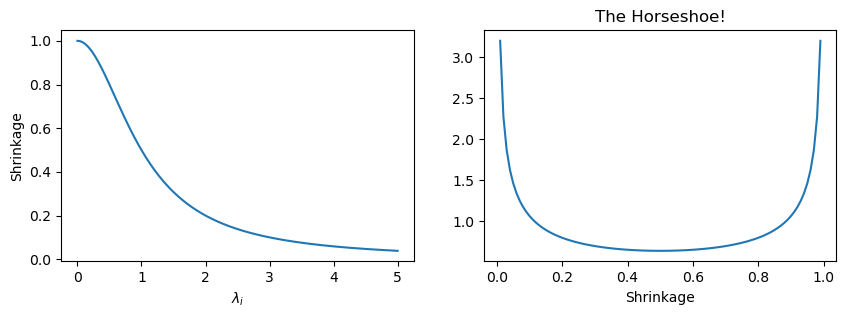

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")
# change of variables:
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage,
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) *
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

References: used OpenAI to generate sections of code.